In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from heterogeneous_model import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
from tqdm import tqdm_notebook
from ternary.helpers import simplex_iterator
import ternary
from scipy.special import comb, perm

# 1) Ternary for $\mathcal{C}$

In [3]:
# Use Minhuan's Codes to generate curves
from scipy.stats import norm
from scipy import integrate

def function_H(T):
    return 1-norm.cdf(T)

def function_in_G(h,x,T):
    return np.exp(-h**2/2)*function_H( ((1-x)*h-T) / np.sqrt(x*(2-x)) )/np.sqrt(2*np.pi)

def function_G(delta_s,f,T):
    Int_res, err = integrate.quad(function_in_G,T,np.inf,args=(delta_s,T))    
    return Int_res/(f*(1-f))

def function_in_I(h1,h2,delta):    
    return np.exp( -0.5*h1**2 - 0.5*h2**2 + 0.5*(1-delta)*h1*h2 ) / (2*np.pi)
    
def function_I(T,delta):    
    T_delta = T / np.sqrt(1-0.25*(1-delta)**2)
    Int_res, err = integrate.dblquad(function_in_I, T_delta, np.inf, lambda h1: T_delta, lambda h1: np.inf, args=(delta,))  
    return Int_res

def s_delta(delta):  
    return np.sqrt(1 - 0.25*(1-delta)**2)

def q1_func(f,T,delta_sigma):
    return f-f*(1-f)*function_G(delta_sigma,f,T)

def q2_func(f,T,delta_eta):
    return f-f*(1-f)*function_G(delta_eta,f,T)

def q_func(p1,p2,p3,f,T,delta_sigma,delta_eta):
    delta_mix = (delta_sigma + delta_eta) / 2.
    delta_m = p1*function_G(delta_sigma,f,T) + p2*function_G(delta_eta,f,T) +  p3*function_G(delta_mix,f,T)
    return f - delta_m*f*(1-f)

def part3_func(Nc,N,M,P,K,p1,p2,p3,f,T,q1,q2,delta_sigma,delta_eta):
    uni_term = Nc*(P*K-1) * f**2 * (1-f)**2
    excess_term1 = Nc*(2*f-1)**2 * ( (K-1)*p1*(q1-f**2) + (P-1)*p2*(q2-f**2) )   
    excess_term2 = Nc*(2*f-1)**2 * p3 * (K-1) * s_delta(delta_sigma) * function_I(T, delta_sigma)  
    excess_term3 = Nc*(2*f-1)**2 * p3 * (P-1) * s_delta(delta_eta) * function_I(T, delta_eta)
    excess_term4 = Nc*(2*f-1)**2 * p3 * f**2 * (P+K-2)
    return uni_term + excess_term1 + excess_term2 + excess_term3 - excess_term4

def compute_part3(f,Nc,N,M,P,K,p1,p2,p3,ds,dc):
    T = norm.ppf(1-f)
    q1 = q1_func(f,T,ds)
    q2 = q2_func(f,T,dc)
    q = q_func(p1,p2,p3,f,T,ds,dc) 
    part3 = part3_func(Nc,N,M,P,K,p1,p2,p3,f,T,q1,q2,ds,dc)
    return part3/(f**2*(1-f)**2*Nc*P*K)- 1

In [4]:
def compute_part3_2(f,q1,q2,p1,p2,p3,ds,dc):
    size1 = erf_full(th,ds,f)
    size2 = erf_full(th,dc,f)
    
    f_one_minus = f*(1-f)
    
    #Peaks
    p_xi = (1/2)*(1 - ds)
    p_phi = (1/2)*(1 - dc)
    
    #Intergral limits
    sqrt_xi = np.sqrt(1 - p_xi**(2))
    sqrt_phi = np.sqrt(1 - p_phi**(2))
    t_xi = th/(sqrt_xi)
    t_phi = th/(sqrt_phi)
    
    #Get the two dimensional integrals
    i_phi = two_dim_i_integral(t_phi,p_phi)
    i_xi = two_dim_i_integral(t_xi,p_xi)
    
    r_xi = f_one_minus*(1-size1)
    r_phi = f_one_minus*(1-size2)
    r_mixed = (q1)*(sqrt_xi)*(i_xi) + (q2)*(sqrt_phi)*(i_phi)  + (1-q1-q2)*f**(2)
    #print("q1+q2",q1+q2)
    #print("r_mixed",r_mixed)

    corr_m = p1*(f**(2) + q1*r_xi) + p2*(f**(2) + q2*r_phi) + p3*r_mixed
    diff = f**(2) - corr_m
    
    rat = (2*f - 1)**(2) / ((f*(1-f))**(2))
    
    f_term = 1 - rat*(diff)
    
    return f_term

In [5]:
def comp_corr(f,tp):
        rat = (2*f - 1)**(2) / ((f*(1-f))**(2))
        diff = f**(2) - tp
        c_term = 1 - rat*(diff)

        return c_term

def compute_empirical(H,N,P,K,th,p1,p2,p3,ds,dc):
    h1,h1_test = generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim=ds,d_cont=dc)

    f = erf1(th)
    m1 = 0.5*(np.sign(h1 - th) + 1) - f
    m1_test = 0.5*(np.sign(h1_test - th) + 1) - f
    
    corrs = []

    for p in range(m1.shape[1]):
        for q in range(m1.shape[1]):
            if p!=q:
                #print("p,q",p,q)
                ov1 = (1/H)*np.dot(m1[:,p],m1_test[:,q])
                corrs.append(comp_corr(f,ov1))
                
    return np.mean(corrs)

In [10]:
H=2100
N=100
P = 400
K = 5
ds = 0.2
dc = 0.2
f= erf1(2.0)

n = 10  # grid size
Record_62= dict()

Peff = int(P*K)
    
q1 = ((K-1)/(Peff-1))
q2 = ((P-1)/(Peff-1))


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    Record_62[(i,j,k)] = compute_part3(f,H,N,N,P,K,p1,p2,p3,ds,dc)

<ipython-input-10-c9c1504745e1>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):


  0%|          | 0/66.0 [00:00<?, ?it/s]

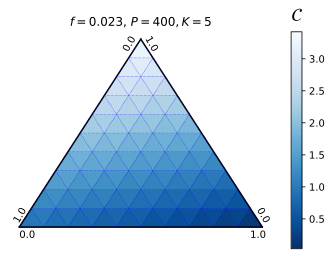

In [11]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_62,scale=n,cmap='Blues_r')
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)

plt.text(11.2,9.5,r'$\mathcal{C}$',fontsize=18)

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$f = {}$, $P = 400, K = 5$'.format(np.round(f,3)),y=1)
#plt.savefig("ternary_c_asymmetric.png")

# 2) Ternary for $Q^{2}$

In [12]:
def two_dim_i_integral(t_in,p):
    """
    Parameters
    ----------
    t_in : Either t_phi or t_xi 
    p: Peak 

    """
    res = integrate.dblquad(func_3dim, t_in, np.inf, lambda x: t_in, lambda x: np.inf,args=(p,))
    return res[0]

def two_dim_g_integral(t_in,p):
    """
    Parameters
    ----------
    t_in : Either t_phi or t_xi 
    p: Peak 

    """
    res = integrate.dblquad(func_3dim_g, t_in, np.inf, lambda x: t_in, lambda x: np.inf,args=(p,))
    return res[0]
    
def excess_over_theory(th,f):
    numer = np.exp(-th**(2))
    denom = 2*np.pi*f*(1-f)
    return numer/denom

def erf_full(T,ds,f):
    res = integrate.dblquad(gaussian_func_2dim, T, np.inf, lambda x: lower_bound(T,ds,x), lambda x: np.inf)
    return 1/(f*(1-f)) * res[0]

In [13]:
def theory_q_arvin(H,N,P,K,th,ds,dc,p1,p2,p3):
    """
    Theory for excess overlap
    """

    erf = erf1(th)
    Peff = P*K
    alpha = Peff/H

    #Get effective qtheory
    f_one_minus = erf*(1-erf) #erf = f 

    #Probabilities in theory
    q1 = (K-1)/(Peff-1)
    q2 = (P-1)/(Peff-1)

    #Peaks
    p_xi = (1/2)*(1 - ds)
    p_phi = (1/2)*(1 - dc)

    #Thresholds
    sqrt_xi = np.sqrt(1 - p_xi**(2))
    sqrt_phi = np.sqrt(1 - p_phi**(2))
    t_xi = th/(sqrt_xi)
    t_phi = th/(sqrt_phi)
    #print("thresholds",t_phi,t_xi)
    #print("BELOW COD!")

    size1 = erf_full(th,ds,erf)
    size2 = erf_full(th,dc,erf)
    ds_eff = 0.5*(ds + dc)
    size3 = erf_full(th,ds_eff,erf)

    #Get G functions
    g_func_generic = (1/(2*np.pi)) * np.exp(-th**(2))
    #g_func_xi = (1/(2*np.pi)) * np.exp(-t_xi**(2))
    #g_func_phi = (1/(2*np.pi)) * np.exp(-t_phi**(2))

    g_func_xi = two_dim_g_integral(t_xi,p_xi)
    g_func_phi = two_dim_g_integral(t_phi,p_phi)

    eo_xi =  (1/N)*excess_over_theory(th,erf)**(2)
    eo_phi = eo_xi
    eo_t_phi = (1/(4*N)) * g_func_phi**(2)
    eo_t_xi = (1/(4*N)) * g_func_xi**(2)
    eo_cross = (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2))) * (1/N)
    eo_sqrt_phi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_phi
    eo_sqrt_xi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_xi
    eo_cross_inter = (1/(2*N)) * (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2)))

    f=erf

    #Get the two dimensional integrals
    i_phi = two_dim_i_integral(t_phi,p_phi)
    i_xi = two_dim_i_integral(t_xi,p_xi)

    #Get the R functions -- > this comes from Eq. 15
    r_xi = f_one_minus*(1-size1)
    r_phi = f_one_minus*(1-size2)
    r_mixed = (q1)*(sqrt_xi)*(i_xi) + (q2)*(sqrt_phi)*(i_phi)  + (1-q1-q2)*f**(2)

    part3_one = (2*f**(3) - 3*f**(4))/(f_one_minus**(2))
    part3_xi = (1/(f_one_minus**(2)))*p1*r_xi*q1
    part3_phi = (1/(f_one_minus**(2)))*p2*q2*r_phi
    part3_mixed = (1/(f_one_minus**(2)))*p3*r_mixed
    part3 = (Peff/H)*(part3_one + (2*f - 1)**(2) * (part3_xi + part3_phi + part3_mixed)) #H = N_{c}
    #print("part3",part3)

    #Terms for intra part
    part4_xi_1 = ((1/f_one_minus)*r_xi*p1)**(2) * q1
    part4_xi_eo = (p1)**(2) * eo_xi * (1-q1)
    part4_phi_1 = ((1/f_one_minus)*r_phi*p2)**(2) * q2
    part4_phi_eo = (p2)**(2) * eo_phi * (1-q2)

    #Part 4 intra for mixed terms
    part4_mixed_four_pt = (q1)*((sqrt_xi*i_xi)**(2) + eo_t_xi) + (q2)*((sqrt_phi*i_phi)**(2) +  eo_t_phi) \
                             + (1 - q1 - q2)*(f**(4) + eo_cross)
    part4_mixed = p3**(2) * (part4_mixed_four_pt - 2*f**(2) * r_mixed + f**(4)) * (1/f_one_minus)**(2)

    i4_intra = Peff * (part4_xi_1 + part4_xi_eo + part4_phi_1 + part4_phi_eo + part4_mixed)
    #print("i4 intra",i4_intra) 

    ##Terms for inter part
    part4_one_three = q1*(r_xi + f**(2))*sqrt_xi*(i_xi)  + \
        (q2)*(f**(2) * sqrt_phi * (i_phi) + sqrt_phi*eo_sqrt_phi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q1*r_xi + r_mixed)
    #part4_one_three = 0
    #print("part4_1_3_parts",part4_one_three + f**(2) * (q1*r_xi + r_mixed),f**(2) * (q1*r_xi + r_mixed))
    part4_two_three = q2*(r_phi + f**(2))*sqrt_phi*(i_phi)  + \
        (q1)*(f**(2) * sqrt_xi * (i_xi) + sqrt_xi*eo_sqrt_xi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q2*r_phi + r_mixed)
    #part4_two_three = 0
    #print("part 4's",part4_one_three,part4_two_three)
    part4_one_two = 0*q1*q2*(r_xi*r_phi)

    part4_full = (1/f_one_minus)**(2) * (2*p1*p2*part4_one_two + 2*p1*p3*part4_one_three + 2*p2*p3*part4_two_three)
    i4_inter = Peff * part4_full
    #print("i4 inter",i4_inter)
    
    return i4_intra + i4_inter

In [14]:
def compute_corr_neurons(m):
    ovs = []
    for i,m1 in enumerate(m):
        for j,m2 in enumerate(m):
            if i!= j:
                print("i,j",i,j)
                print("m1*m2",m1*m2)
                ovs.append(m1*m2)
     
    print("ovs",ovs)
    return np.mean(ovs)


def compute_empirical_q(H,N,P,K,th,p1,p2,p3,ds,dc):
    h1,h1_test = generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim=ds,d_cont=dc)

    f = erf1(th)
    m1 = 0.5*(np.sign(h1 - th) + 1) - f
    m1_test = 0.5*(np.sign(h1_test - th) + 1) - f
    
    corrs = []

    for p in range(m1.shape[1]):
        for q in range(m1.shape[1]):
            if p!=q:
                print("p,q",p,q)
                for i in range(m1.shape[0]):
                    for j in range(m1.shape[0]):
                        corr = m1[i,p]*m1[j,p]*m1_test[i,q]*m1_test[j,q]
                        ov1 = (1/((f*(1-f))**(2)))*corr
                        #print("ov1",ov1)
                        corrs.append(ov1)
                
    return N*np.mean(corrs)

In [15]:
H=2100
N=100
P = 200
K = 5
ds = 0.2
dc = 0.2
th = 1.0
f= erf1(th)
print("f",f)

n = 10  # grid size
Record_Q_2 = dict()

Peff = int(P*K)
    
q1 = ((K-1)/(Peff-1))
q2 = ((P-1)/(Peff-1))


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    Record_Q_2[(i,j,k)] = theory_q_arvin(H,N,P,K,th,ds,dc,p1,p2,p3)

f 0.15865525393145707


<ipython-input-15-3e1a11b55823>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):


  0%|          | 0/66.0 [00:00<?, ?it/s]

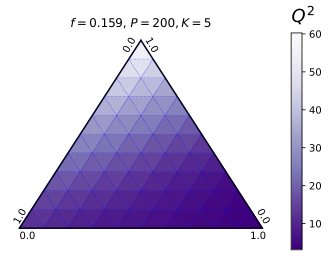

In [16]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_Q_2,scale=n,cmap='Purples_r')
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)

plt.text(11.2,9.5,r'$Q^{2}$',fontsize=18)

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$f = {}$, $P = 200, K = 5$'.format(np.round(f,3)),y=1)
#plt.savefig("ternary_q_asymm.png")

In [18]:
import pickle
file = open("q_emps_th1.0_50real_P10_K10.pkl",'rb')
q_emps = pickle.load(file)
file.close()

file2 = open("q_theorys_50real_th1.0_P10_K10.pkl",'rb')
q_theorys = pickle.load(file2)
file2.close()

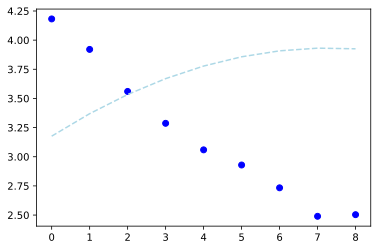

In [20]:
plt.figure()
plt.plot(range(len(q_emps)),q_emps,'o',color='blue')
plt.plot(range(len(q_theorys)),q_theorys,'--',color='lightblue')
plt.show()

In [31]:
P = 200
K = 200
H = 21000
N = 100
ds = 0.1
dc = 0.1
th = 1.0
f= erf1(th)

Peff = int(P*K)
    
q1 = ((K-1)/(Peff-1))
q2 = ((P-1)/(Peff-1))

p3_list = list(np.linspace(0.1,0.9,9))

for i,p3 in enumerate(p3_list):
    diff = 1 - p3
    p2 = diff/2
    p1 = p2
    q_emps_real = []
#     for r in range(50):
#         print("relization",r)
#         q_emps_real.append(compute_empirical_q(H,N,P,K,th,p1,p2,p3,ds,dc))
    q_theorys[i] = theory_q_arvin(H,N,P,K,th,ds,dc,p1,p2,p3)

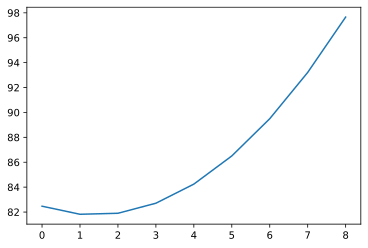

In [32]:
plt.plot(range(len(q_theorys)),q_theorys)